In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

df = pd.read_csv("./data/flight_crashed_output.csv").dropna()

In [4]:
df["Date"]=pd.to_datetime(df["Date"], format="%d.%m.%Y")
df.dtypes

Date                            datetime64[ns]
Route                                   object
Start - Flughafen                       object
Start-Flughafen_country_code            object
Start-Flughafen_Code                    object
Start-Flughafen_latitude                object
Start-Flughafen_longitude               object
Ziel - Flughafen                        object
Ziel-Flughafen_country_code             object
Zeiel-Flughafen_code                    object
Ziel-Flughafen_latitude                 object
Ziel-Flughafen_longitude                object
Absturzland                             object
Operator                                object
Aboard                                   int64
Fatalities                               int64
dtype: object

In [5]:
df = df.groupby(['Absturzland']).sum()
df.reset_index(level=0, inplace=True)
df

,Absturzland,Aboard,Fatalities
0,AFGHANISTAN,306,306
1,ANGOLA,124,118
2,ARGENTINA,236,156
3,AUSTRALIA,24,23
4,AUSTRIA,9,9
...,...,...,...
82,UZBEKISTAN,37,37
83,VENEZUELA,56,29
84,YEMEN,122,50
85,ZAMBIA,13,13


In [6]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

In [7]:
def get_countrycode(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col, cn_name_format='upper')
    except:
        cn_a2_code = 'Unknown' 
    return (cn_a2_code)

def get_continent(cn_a2_code):
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_continent)

In [8]:
df['countrycode'] = df['Absturzland'].apply(get_countrycode)
df['continent'] = df['countrycode'].apply(get_continent)
df.head()

,Absturzland,Aboard,Fatalities,countrycode,continent
0,AFGHANISTAN,306,306,AF,AS
1,ANGOLA,124,118,AO,AF
2,ARGENTINA,236,156,AR,SA
3,AUSTRALIA,24,23,AU,OC
4,AUSTRIA,9,9,AT,EU


In [9]:
from geopy.geocoders import Nominatim

In [10]:
geolocator = Nominatim()

def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.latitude, loc.longitude)
    except:
        # Return missing value
        return np.nan

/Users/alessandro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [11]:
df['geolocate'] = df['countrycode'].apply(geolocate)

In [12]:
# new data frame with split value columns 
new = pd.DataFrame(df['geolocate'].tolist(), index=df.index)

# making separate first name column from new data frame 
df["absturz-lat"]= new[0]
  
# making separate last name column from new data frame 
df["absturz-lon"]= new[1]

df.head()

,Absturzland,Aboard,Fatalities,countrycode,continent,geolocate,absturz-lat,absturz-lon
0,AFGHANISTAN,306,306,AF,AS,"(33.7680065, 66.2385139)",33.768006,66.238514
1,ANGOLA,124,118,AO,AF,"(47.2000338, 13.199959)",47.200034,13.199959
2,ARGENTINA,236,156,AR,SA,"(-34.9964963, -64.9672817)",-34.996496,-64.967282
3,AUSTRALIA,24,23,AU,OC,"(-24.7761086, 134.755)",-24.776109,134.755000
4,AUSTRIA,9,9,AT,EU,"(47.2000338, 13.199959)",47.200034,13.199959


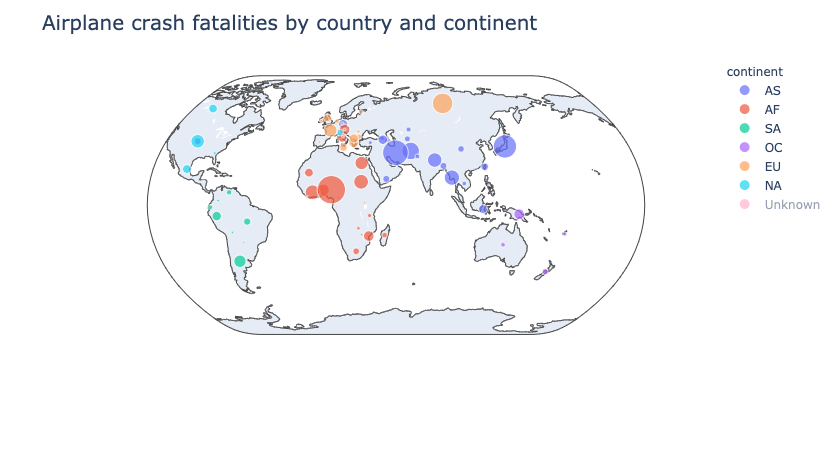

In [329]:
import plotly.express as px

fig = px.scatter_geo(df, lon="absturz-lon", lat="absturz-lat",
                     color="continent", # which column to use to set the color of markers
                     hover_name="Absturzland", # column added to hover information
                     size="Fatalities", # size of markers
                     projection="natural earth")
fig.update_layout(title_text="Airplane crash fatalities by country and continent",
                  title_font_size=20)
fig.show()

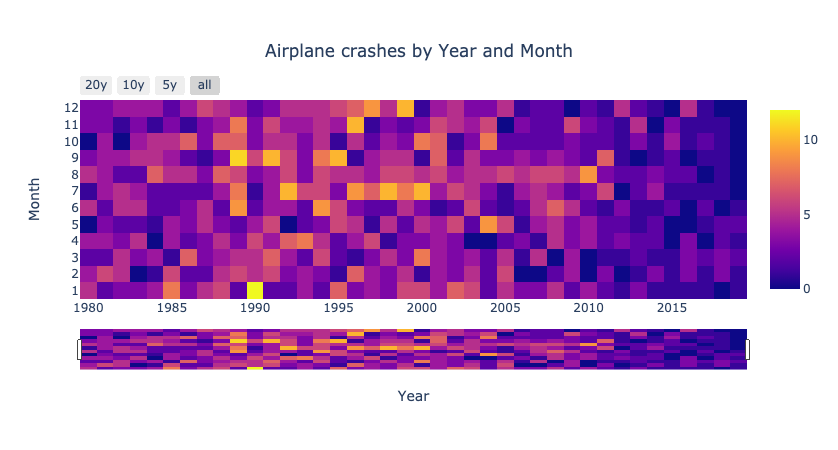

In [331]:
df_4 = pd.read_csv("./data/flight_crashed_output.csv", usecols=['Date'])
df_4["Date"]=pd.to_datetime(df_4["Date"], format="%d.%m.%Y")
df_4['Year'] = df_4.Date.dt.year
df_4['Month'] = df_4.Date.dt.month
df_4 = df_4.drop('Date', 1)
df_4 = df_4.pivot_table(index='Month', columns='Year', values='Month', aggfunc=len, fill_value=0)

import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=df_4,
                   x=df_4.columns,
                   y=df_4.index,
                   hoverongaps = True),
                   layout=go.Layout(
                       title=
                       {'text':"Airplane crashes by Year and Month",
                       'xanchor': 'center',
                        'yanchor': 'top',
                        'y':0.9,
                        'x':0.5,
                       },
                       xaxis_title="Year",
                       yaxis_title="Month")
               )

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=20,
                     label="20y",
                     step="year",
                     stepmode="backward"),
                dict(count=10,
                     label="10y",
                     step="year",
                     stepmode="backward"),
                dict(count=5,
                     label="5y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.update_yaxes(tick0=1, dtick=1)
fig.show()